In [33]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import torch.optim as optim
from PIL import Image
import time

# READ IMAGES

In [34]:
def read_images(path, numberofImage):
    array = np.zeros([numberofImage, 64*32])
    i = 0
    for img in os.listdir(path):
        img_path = path + "/" + img
        img = Image.open(img_path, mode = "r")
        data = np.asarray(img, dtype = "uint8")
        data = data.flatten()
        array[i,:] = data
        i += 1
    return array

# READ DATA

In [35]:
res_Train_neg_path = r"/Users/erdemsevinc/Desktop/python/WEEK 11/LSIFIR/Classification/Train/neg"
res_num_Train_neg_img = 43390
res_Train_neg_array = read_images(res_Train_neg_path, res_num_Train_neg_img)

x_res_Train_neg_Tensor = torch.from_numpy(res_Train_neg_array[:42000,:])
print("Size of x_Train_neg_Tensor: ", x_res_Train_neg_Tensor.size())

# I specify negative images as zero.
y_res_Train_neg_Tensor = torch.zeros(42000, dtype = torch.long)
print("Size of y_Train_neg_Tensor: ", y_res_Train_neg_Tensor.size())

res_Train_pos_path = r"/Users/erdemsevinc/Desktop/python/WEEK 11/LSIFIR/Classification/Train/pos"
res_num_Train_pos_img = 10208
res_Train_pos_array = read_images(res_Train_pos_path, res_num_Train_pos_img)

x_res_Train_pos_Tensor = torch.from_numpy(res_Train_pos_array[:10000,:])
print("Size of x_Train_pos_Tensor: ", x_res_Train_pos_Tensor.size())

# I specify negative images as one.
y_res_Train_pos_Tensor = torch.ones(10000, dtype = torch.long)
print("Size of y_Train_pos_Tensor: ", y_res_Train_pos_Tensor.size())

X_res_train = torch.cat((x_res_Train_neg_Tensor, x_res_Train_pos_Tensor),0)
Y_res_train = torch.cat((y_res_Train_neg_Tensor, y_res_Train_pos_Tensor),0)

print("Size of X_train: ",X_res_train.size())
print("Size of Y_train: ",Y_res_train.size()) 

res_Test_neg_path = r"/Users/erdemsevinc/Desktop/python/WEEK 11/LSIFIR/Classification/Test/neg"
res_num_Test_neg_img = 22050
res_Test_neg_array = read_images(res_Test_neg_path, res_num_Test_neg_img)

x_res_Test_neg_Tensor = torch.from_numpy(res_Test_neg_array[:18056,:])
print("Size of x_Train_neg_Tensor: ", x_res_Test_neg_Tensor.size())

# I specify negative images as zero.
y_res_Test_neg_Tensor = torch.zeros(18056, dtype = torch.long)
print("Size of y_Train_neg_Tensor: ", y_res_Test_neg_Tensor.size())

res_Test_pos_path = r"/Users/erdemsevinc/Desktop/python/WEEK 11/LSIFIR/Classification/Test/pos"
res_num_Test_pos_img = 5944
res_Test_pos_array = read_images(res_Test_pos_path, res_num_Test_pos_img)

x_res_Test_pos_Tensor = torch.from_numpy(res_Test_pos_array)
print("Size of x_Train_neg_Tensor: ", x_res_Test_pos_Tensor.size())

# I specify negative images as one.
y_res_Test_pos_Tensor = torch.ones(res_num_Test_pos_img, dtype = torch.long)
print("Size of y_Train_neg_Tensor: ", y_res_Test_pos_Tensor.size())

X_res_test = torch.cat((x_res_Test_neg_Tensor, x_res_Test_pos_Tensor),0)
Y_res_test = torch.cat((y_res_Test_neg_Tensor, y_res_Test_pos_Tensor),0)

print("Size of X_train: ",X_res_test.size())
print("Size of Y_train: ",Y_res_test.size()) 

res_batch_size = 2000

# Last prepare data
res_train = torch.utils.data.TensorDataset(X_res_train, Y_res_train)
res_trainloader = torch.utils.data.DataLoader(res_train, batch_size = res_batch_size, shuffle = True)

res_test = torch.utils.data.TensorDataset(X_res_test, Y_res_test)
res_testloader = torch.utils.data.DataLoader(res_test, batch_size = res_batch_size, shuffle = False)

Size of x_Train_neg_Tensor:  torch.Size([42000, 2048])
Size of y_Train_neg_Tensor:  torch.Size([42000])
Size of x_Train_pos_Tensor:  torch.Size([10000, 2048])
Size of y_Train_pos_Tensor:  torch.Size([10000])
Size of X_train:  torch.Size([52000, 2048])
Size of Y_train:  torch.Size([52000])
Size of x_Train_neg_Tensor:  torch.Size([18056, 2048])
Size of y_Train_neg_Tensor:  torch.Size([18056])
Size of x_Train_neg_Tensor:  torch.Size([5944, 2048])
Size of y_Train_neg_Tensor:  torch.Size([5944])
Size of X_train:  torch.Size([24000, 2048])
Size of Y_train:  torch.Size([24000])


# VISUALIZE

(-0.5, 31.5, 63.5, -0.5)

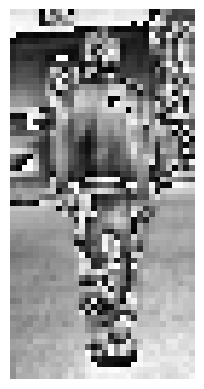

In [37]:
plt.imshow(X_res_train[45001,:].reshape(64,32),cmap = "gray")
plt.axis("off")


# HYPER PARAMETERS

In [38]:
res_numberofepochs = 10
res_numberofclasses = 2
res_learning_rate = 0.0001

# BLOCKS

In [44]:
def conv3x3(in_planes, out_planes, stride = 1):
    return nn.Conv2d(in_planes, out_planes, kernel_size = 3, stride = stride, padding = 1, bias = False)

def conv1x1(in_planes, out_planes, stride = 1):
    return nn.Conv2d(in_planes, out_planes, kernel_size = 1, stride = stride, bias = False)

class ResNetBasicBlock(nn.Module):
    
    expansion = 1
    
    def __init__(self, inplanes, planes, stride = 1, downsample = None):
        super(ResNetBasicBlock,self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace = True)
        self.drop = nn.Dropout(0.9)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride
        
    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.drop(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.drop(out)
        
        if self.downsample is not None:
            identity = self.downsample(x)
        out = out + identity
        out = self.relu(out)
        return out
    
class ResNet(nn.Module):
    
    def __init__(self, block, layers, num_classes = res_numberofclasses):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(1, 64, kernel_size = 7, stride = 2, padding = 3, bias = False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace = True)
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer1 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride = 2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(256*block.expansion, res_numberofclasses)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode = "fan_out", nonlinearity = "relu")
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
                
    
    def _make_layer(self, block, planes, blocks, stride = 1):
        downsample = None
        
        if stride != 1 or self.inplanes != planes*block.expansion:
            downsample = nn.Sequential(conv1x1(self.inplanes, planes * block.expansion, stride),
                                      nn.BatchNorm2d(planes*block.expansion))
            
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes*block.expansion
        for _ in range(1,blocks):
            layers.append(block(self.inplanes, planes))
            
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        
        return x
    
res_model = ResNet(ResNetBasicBlock, [2,2,2])

# For GPU
# res_model = ResNet(ResNetBasicBlock, [2,2,2]).to(device)

res_criterion = nn.CrossEntropyLoss()

res_optimizer = torch.optim.Adam(res_model.parameters(), lr = res_learning_rate)



# OPTIMIZER

In [45]:
res_criterion = nn.CrossEntropyLoss()

res_optimizer = torch.optim.Adam(res_model.parameters(), lr = res_learning_rate)

# TRAINING MODEL

In [46]:
res_start = time.time() # start of time
res_train_acc = []
res_test_acc = []
res_loss_list = []

use_gpu = False # If you want to use GPU, Change True

res_total_step = len(res_trainloader)

for epoch in range(res_numberofepochs):
    for i, (images, labels) in enumerate(res_trainloader):
        
        images = images.view(res_batch_size, 1, 64, 32)
        images = images.float()
        
        # GPU
        if use_gpu:
            if torch.cuda.is_available():
                images, labels = images.to(device), labels.to(device)
                
        outputs = res_model(images)
        
        loss = res_criterion(outputs, labels)
        
        # backward and optimization
        res_optimizer.zero_grad()
        loss.backward()
        res_optimizer.step()
        """
        if i % 2 == 0:
            print("epoch: {} {}\{}".format(epoch, i, res_total_step))
        """ 
    # train
    res_train_correct = 0
    res_train_total = 0
    with torch.no_grad():
        for data in res_trainloader:
            images, labels = data
            images = images.view(res_batch_size, 1, 64, 32)
            images = images.float()
            
            # GPU
            if use_gpu:
                if torch.cuda.is_available():
                    images, labels = images.to(device), labels.to(device)
                    
            outputs = res_model(images)
            _, predicted = torch.max(outputs.data, 1)
            res_train_total += labels.size(0)
            res_train_correct += (predicted == labels).sum().item()
            
    Accuracy_Train = 100* res_train_correct/res_train_total
    #print("Accuracy Train: "(Accuracy_Train)
    res_train_acc.append(Accuracy_Train)
    
    # test
    res_test_correct = 0
    res_test_total = 0
    with torch.no_grad():
        for data in res_testloader:
            images, labels = data
            images = images.view(res_batch_size, 1, 64, 32)
            images = images.float()
            
            # GPU
            if use_gpu:
                if torch.cuda.is_available():
                    images, labels = images.to(device), labels.to(device)
                    
            outputs = res_model(images)
            _, predicted = torch.max(outputs.data, 1)
            res_test_total += labels.size(0)
            res_test_correct += (predicted == labels).sum().item()
          
    Accuracy_Test = 100* res_test_correct/res_test_total
    #print("Accuracy Test: "(Accuracy_Test)
    res_test_acc.append(Accuracy_Test)
    
    res_loss_list.append(loss.item())
          
    print("Epoch: {} | Accuracy Train: {} | Accuracy Test: {} | Loss: {} ".format(epoch, Accuracy_Train, Accuracy_Test, loss.item()))
    
print("Training is Done")

# time of end
res_end = time.time()
res_process_time = (res_end - res_start)/60
print("Process Time: ",res_process_time)

        

Epoch: 0 | Accuracy Train: 79.38076923076923 | Accuracy Test: 74.20416666666667 | Loss: 0.5235095024108887 
Epoch: 1 | Accuracy Train: 79.74423076923077 | Accuracy Test: 73.6125 | Loss: 0.45060956478118896 


KeyboardInterrupt: 

# VISUALIZE

ValueError: x and y must have same first dimension, but have shapes (10,) and (2,)

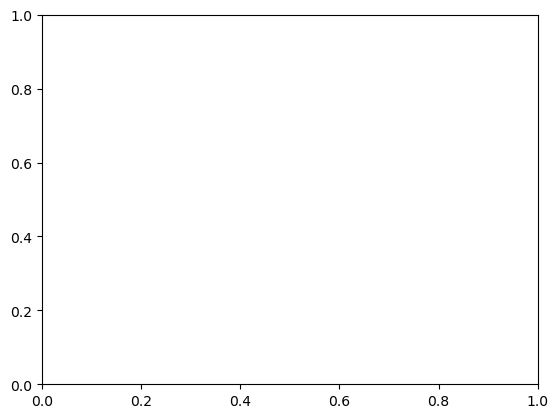

In [47]:
res_epochs = []
for i in range(res_numberofepochs):
    res_epochs.append(i)

plt.plot(res_epochs, res_train_acc, label="Train")
plt.plot(res_epochs, res_test_acc, label="Test")
plt.title("Train-Test Accuracy")
plt.xlabel("Number of Epochs")
plt.xlabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
plt.plot(res_loss_list)
plt.title("Loss of ResNet Model")
plt.xlabel("Index of loss_list")
plt.ylabel("Loss")
plt.show()